In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.constants as SI
import scipy.optimize as opt

In [2]:
#SI.constants
Ee = 500e9*SI.e
e = SI.e
me = SI.m_e
re = SI.physical_constants['classical electron radius'][0]

n0 = 7e21 #m⁻³
L_plasma = 5 #m

wp = np.sqrt(n0*e**2/me/SI.epsilon_0)
print(wp)
kp = wp/SI.c
#E0 = me*SI.c*wp/e
E0 = 96e9 * np.sqrt(n0/1e24)
Ez = 0.56*E0 #V/m
tau_r = 2*re/3/SI.c

K = kp/ np.sqrt(2)
A = tau_r * SI.c**2 * K**2
B = SI.c**2 * K**2
C = wp*Ez/E0
D = tau_r * SI.c**2 * K**4

gamma0 = Ee/me/(SI.c**2)

beta_matched = np.sqrt(2*gamma0)/kp
lambda_beta = 2*np.pi*beta_matched
print(lambda_beta)
k_beta = 2*np.pi/lambda_beta
emittance_norm = 10e-6 # m rad

sig_x = np.sqrt(beta_matched*emittance_norm/gamma0)
print(sig_x)
sig_xp = np.sqrt(1/beta_matched * emittance_norm/gamma0)

4719984266710.515
0.5582773603876113
9.529279729566272e-07


In [3]:
T = L_plasma/SI.c
n_per_beta = 500
n = round(L_plasma/lambda_beta * n_per_beta)
t, dt = np.linspace(0,T,n, retstep = True)
t_span = (0,T)

def oscillator2d(t, x):
    # x= [x,v_x, y, vy, gamma, z ,v_z]
    x_, vx_, y_, vy_, gamma_, z_, vz_ = x
    
    a_x = -(C/gamma_ + A)*vx_ - B/gamma_*x_
    a_y = -(C/gamma_ + A)*vy_ - B/gamma_*y_
    
    d_gamma = C - D*gamma_**2*(x_**2 + y_**2)
    
    v_z = np.sqrt(SI.c**2 - vx_**2 -vy_**2)
    a_z = 0
    #d_gamma= 0
    return np.array([vx_, a_x, vy_, a_y, d_gamma, v_z, a_z])

def oscillator(t, x):
    # x= [x,v_x, gamma, z ,v_z]
    v_x = x[1]
    a_x = -(C/x[2] + A)*v_x - B/x[2]*x[0]
    d_gamma = C - D*x[2]**2*x[0]**2
    v_z = np.sqrt(SI.c**2 - v_x**2)
    a_z = 0
    #d_gamma= 0
    return np.array([v_x, a_x, d_gamma, v_z, a_z])

In [13]:
def plot_oscillations(func, sysinit, t_span, t_eval):
    solution = solve_ivp(fun = func, y0 = sysinit, method='RK45', t_span = t_span, t_eval = t_eval)
    x_ivp = solution.y[0,:]
    vx_ivp = solution.y[1,:]
    y_ivp = solution.y[2,:]
    vy_ivp = solution.y[3,:]
    print(vx_ivp[-1])
    
    gamma_ivp = solution.y[4,:]
    t_ivp = solution.t
    z_ivp = solution.y[5,:]
    vz_ivp = solution.y[6,:]
    energy_ivp = gamma_ivp*me*SI.c**2
    
    total_energy_change = np.zeros(n-1)
    v_dot_a = np.zeros(n-1)
    P = np.zeros(n-1)
    z = np.zeros(n-1)
    energy_change = np.zeros(n-1)
    energy_gain_per_m = np.zeros(n-1)
    
    for i in range(n-1):
        ax = (vx_ivp[i+1] - vx_ivp[i])/dt
        ay = (vy_ivp[i+1] - vy_ivp[i])/dt
        az = (vz_ivp[i+1] - vz_ivp[i])/dt
        
        v_dot_a = ax*vx_ivp[i] + az*vz_ivp[i] + ay*vy_ivp[i]
        a = np.array([ax, ay, az])
        v = np.array([vx_ivp[i], vy_ivp[i], vz_ivp[i]])
        z[i] = z_ivp[i]
        A1 = gamma_ivp[i]**4 *np.dot(a,a)
        A2 = gamma_ivp[i]**6 + v_dot_a**2/SI.c**2
        
        P[i] = 1/SI.c * e**2/6/np.pi/SI.epsilon_0 * 1/SI.c**3 * (A1+A2) # J*m⁻¹
        energy_change[i] = Ez  - P[i]/e
        energy_gain_per_m[i] = 1/SI.c * wp*Ez/E0* SI.m_e*SI.c**2
        
        total_energy_change[i] = 1/SI.c * (energy_ivp[i+1]-energy_ivp[i])/dt # J*m⁻¹
        
    fig, ax = plt.subplots(figsize=(12,9))
    #ax[0,0].plot(z_ivp,x_ivp*1e6)
    #ax[0,0].grid()
    #ax[0,0].set_ylabel('x (um)')
    #ax[0,0].set_xlabel('s (m)')
    #
    #ax[0, 1].plot(z_ivp,y_ivp*1e6)
    #ax[0, 1].grid()
    #ax[0, 1].set_ylabel('y (um)')
    #ax[0, 1].set_xlabel('s (m)')
    #
    #ax[1, 0].plot(z_ivp,vx_ivp)
    #ax[1, 0].grid()
    #ax[1, 0].set_ylabel('vx (m/s)')
    #ax[1, 0].set_xlabel('s (m)')
    
    ax.plot(z,(energy_gain_per_m - total_energy_change)/e*1e-9, label = 'simulated')
    ax.scatter(z,P/e*1e-9, label = 'larmor formula', s=0.1, color = 'r')
    ax.grid()
    ax.set_ylabel('P (GeV/m)')
    ax.set_xlabel('s (m)')
    ax.legend()
    return x_ivp, z_ivp, energy_ivp, fig

0
7044.025783089545


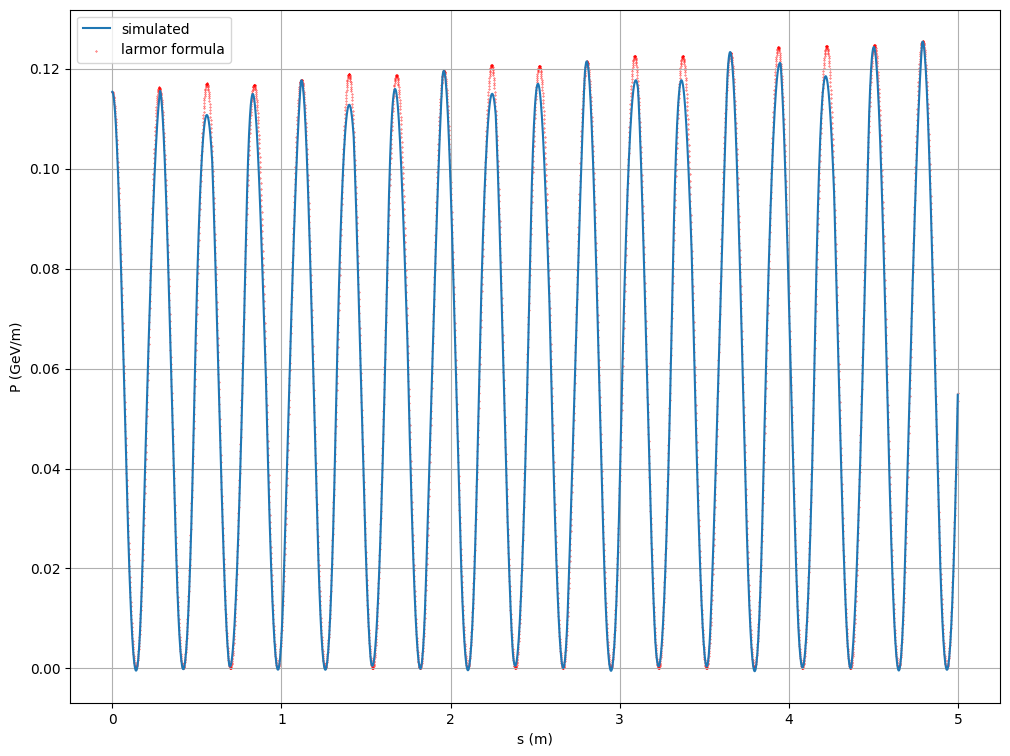

In [14]:
z0 = 0 # m
x0 = 3*sig_x # m
y0 = 0 # m
x_dot0 = 0 # m/s
print(x_dot0)
y_dot0 = 0 # m/s

sysinit2dx = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig = plot_oscillations(func = oscillator2d, sysinit = sysinit2dx, t_span = t_span, t_eval = t)
fig.savefig('single_particle_simulation.png')

0.0


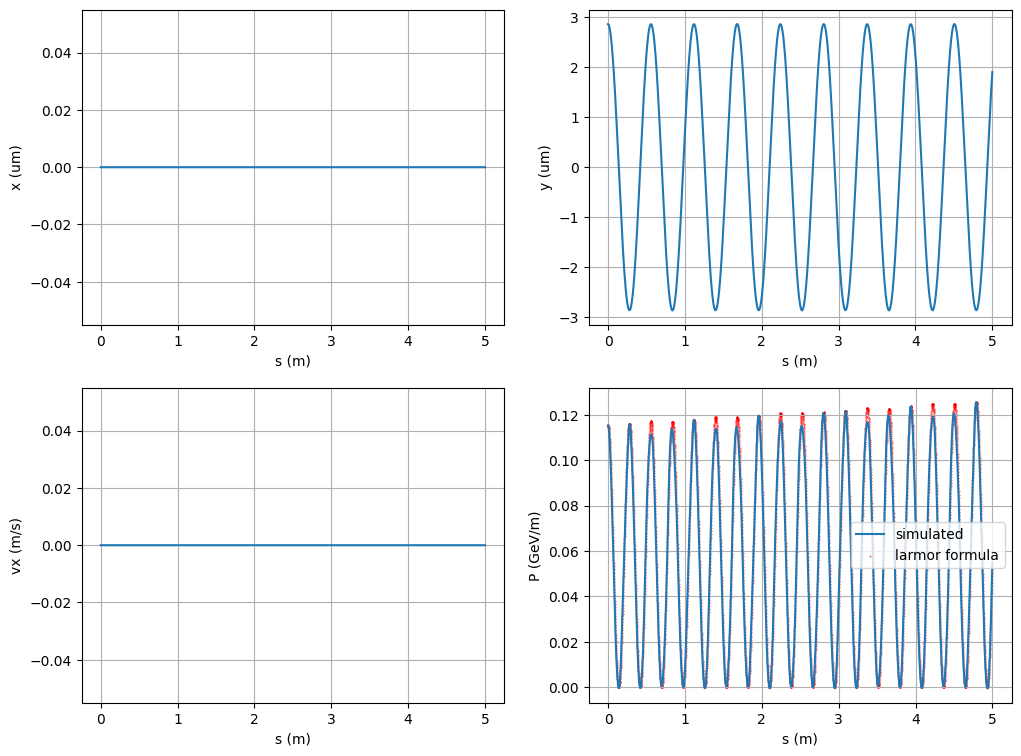

In [6]:
x0 = 0 # m
y0 = 3*sig_x # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2dy = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, 0])

xs, zs, Es = plot_oscillations(func = oscillator2d, sysinit = sysinit2dy, t_span = t_span, t_eval = t)

9133.112622386041


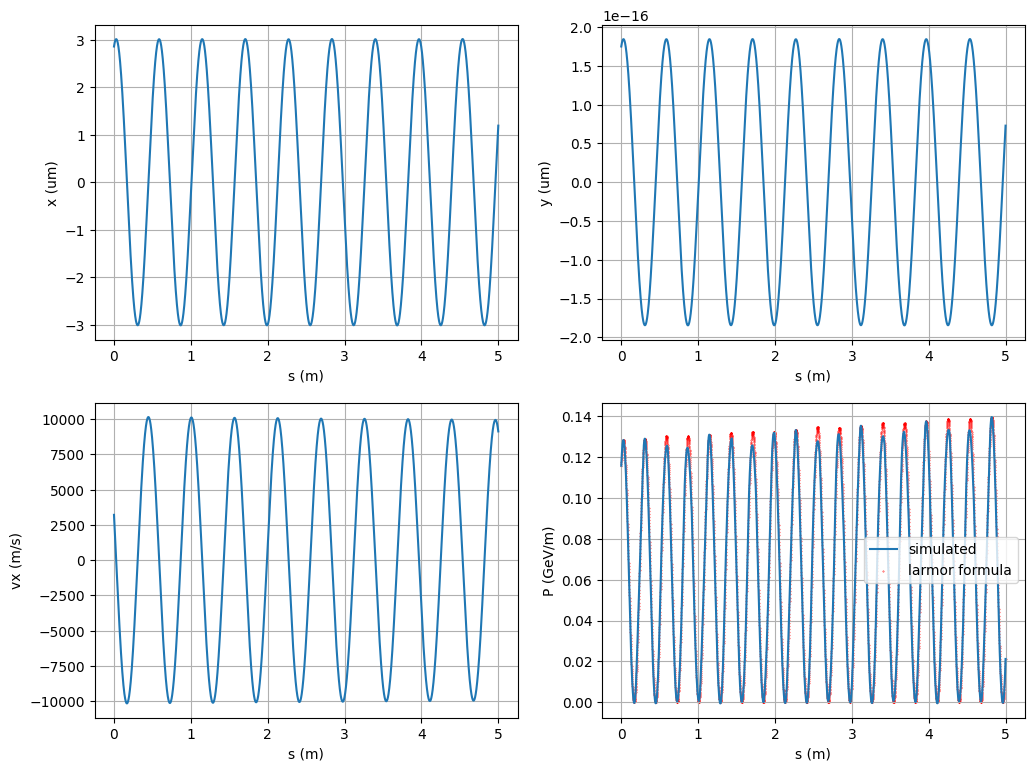

In [7]:
theta = np.pi/2
x0 = 3*sig_x*np.sin(theta) # m
y0 = 3*sig_x*np.cos(theta) # m
x_dot0 = sig_xp*SI.c*np.sin(theta) # m/s
y_dot0 = sig_xp*SI.c*np.cos(theta) # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, 0])


xs, zs, Es = plot_oscillations(func = oscillator2d, sysinit = sysinit2d45, t_span = t_span, t_eval = t)

fig2 = plt.figure(figsize=(8,6))
plt.plot(z, energy_change*1e-9, label = 'analytic')
plt.plot(z,total_energy_change/e*1e-9, label = 'simulated')
plt.xlabel('z (m)')
plt.ylabel('P (GeV/m)')
plt.legend()

5008.4452681540315


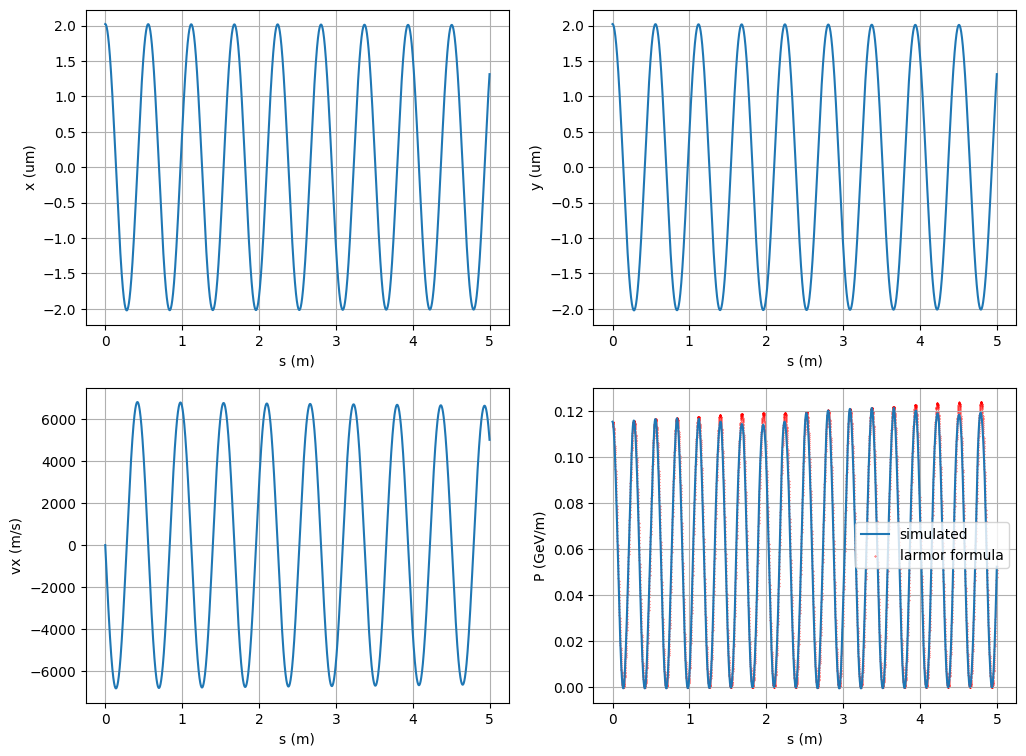

In [8]:
x0 = 3*sig_x*np.sin(np.pi/4) # m
y0 = 3*sig_x*np.cos(np.pi/4) # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, 0])

xs, zs, Es = plot_oscillations(func = oscillator2d, sysinit = sysinit2d45, t_span = t_span, t_eval = t)

In [9]:
print(1/SI.c*(SI.e**2/6/np.pi/SI.epsilon_0/SI.c**3 * (Ee/SI.m_e/SI.c**2)**4 * (3*sig_x*k_beta**2*SI.c**2)**2)/e*1e-9)

0.11538320435981884


In [12]:
3*sig_x

2.8587839188698816e-06